<a href="https://colab.research.google.com/github/mshitie/MS_KD/blob/main/Teacher%26Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install rarfile

from google.colab import drive
import rarfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the .rar file in Google Drive
rar_path = '/content/drive/MyDrive/computer_vision/main_data_croped.rar'

# Destination folder to extract the contents
destination_folder = '/content'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Extract the .rar file
with rarfile.RarFile(rar_path, 'r') as rar_ref:
    rar_ref.extractall(destination_folder)

print("Extraction completed.")

Mounted at /content/drive
Extraction completed.


In [2]:
import os
import csv
import shutil
import random

def partition_images(directory, csv_file, output_folder):
    image_files = []
    folder_counts = {}  # Dictionary to store the count of images moved to each folder

    # Read the CSV file
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        header = next(reader, None)  # Skip the header row if it exists

        # Iterate over the rows in the CSV file
        for row in reader:
            image_file = row[0]  # Assuming the image file names are in the first column
            label = row[1]  # Assuming the labels are in the second column
            image_files.append((image_file, label))

    # Create directories for each label in training and testing folders
    labels = set(label for _, label in image_files)
    train_folder = os.path.join(output_folder, "training")
    test_folder = os.path.join(output_folder, "testing")
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    folder_counts["training"] = 0  # Initialize the count for training folder
    folder_counts["testing"] = 0  # Initialize the count for testing folder

    # Move the image files to separate label directories in training and testing folders
    for image_file, label in image_files:
        source_path = os.path.join(directory, image_file + ".jpg")  # Assuming the file extension is '.jpg'

        if os.path.exists(source_path):
            if random.random() < 0.2:
                destination_path = os.path.join(test_folder, label, image_file + ".jpg")
                folder_counts["testing"] += 1
            else:
                destination_path = os.path.join(train_folder, label, image_file + ".jpg")
                folder_counts["training"] += 1

            destination_dir = os.path.dirname(destination_path)
            os.makedirs(destination_dir, exist_ok=True)

            print(f"Moving {source_path} to {destination_path}")
            shutil.move(source_path, destination_path)
        else:
            print(f"File not found: {source_path}")

    # Print the counts for each folder
    print("\nNumber of images moved in each folder:")
    for folder, count in folder_counts.items():
        print(f"{folder}: {count}")

# Directory path where the images and CSV file are located
directory_path = '/content/main_data_croped/'
csv_file_path = '/content/drive/MyDrive/computer_vision/tfti2.csv'
output_folder = "/content/main_data_croped3/"

# Create the output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Call the function to partition the images based on the labels
partition_images(directory_path, csv_file_path, output_folder)

Moving /content/main_data_croped/image1.jpg to /content/main_data_croped3/training/1/image1.jpg
Moving /content/main_data_croped/image2.jpg to /content/main_data_croped3/training/2/image2.jpg
Moving /content/main_data_croped/image3.jpg to /content/main_data_croped3/training/1/image3.jpg
Moving /content/main_data_croped/image4.jpg to /content/main_data_croped3/training/1/image4.jpg
Moving /content/main_data_croped/image5.jpg to /content/main_data_croped3/training/2/image5.jpg
Moving /content/main_data_croped/image6.jpg to /content/main_data_croped3/training/3/image6.jpg
Moving /content/main_data_croped/image7.jpg to /content/main_data_croped3/training/1/image7.jpg
Moving /content/main_data_croped/image8.jpg to /content/main_data_croped3/training/4/image8.jpg
Moving /content/main_data_croped/image9.jpg to /content/main_data_croped3/training/1/image9.jpg
Moving /content/main_data_croped/image10.jpg to /content/main_data_croped3/training/4/image10.jpg
Moving /content/main_data_croped/image

In [3]:
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

import time
import timeit

<ipython-input-3-394d0b1b32f1>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
import keras
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D , Conv2D , MaxPooling2D
from keras.layers import  Dropout , BatchNormalization , Dense
from keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy

In [7]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


train_dir = '/content/main_data_croped3/training'
test_dir = '/content/main_data_croped3/testing'

# Load train images
tf_train = []
for filename in os.listdir(os.path.join(train_dir, 'TF')):
    img = Image.open(os.path.join(train_dir, 'TF', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    tf_train.append(img_array)
tf_train = np.array(tf_train)

it_train = []
for filename in os.listdir(os.path.join(train_dir, 'TI')):
    img = Image.open(os.path.join(train_dir, 'TI', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    it_train.append(img_array)
it_train = np.array(it_train)

normal_train = []
for filename in os.listdir(os.path.join(train_dir, 'normal')):
    img = Image.open(os.path.join(train_dir, 'normal', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    normal_train.append(img_array)
normal_train = np.array(normal_train)

# Load test images
tf_test = []
for filename in os.listdir(os.path.join(test_dir, 'TF')):
    img = Image.open(os.path.join(test_dir, 'TF', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    tf_test.append(img_array)
tf_test = np.array(tf_test)

it_test = []
for filename in os.listdir(os.path.join(test_dir, 'TI')):
    img = Image.open(os.path.join(test_dir, 'TI', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    it_test.append(img_array)
it_test = np.array(it_test)

normal_test = []
for filename in os.listdir(os.path.join(test_dir, 'normal')):
    img = Image.open(os.path.join(test_dir, 'normal', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    normal_test.append(img_array)
normal_test = np.array(normal_test)

print('Done Loaded :)')

# Shape of our dataset
print(f'TF Train:', tf_train.shape)
print(f'TI Train:', it_train.shape)
print(f'Normal Train:', normal_train.shape)
print(f'TF Test:', tf_test.shape)
print(f'TI Test:', it_test.shape)
print(f'Normal Test:', normal_test.shape)

tf_train_label = np.zeros(len(tf_train), dtype=float)
it_train_label = np.ones(len(it_train), dtype=float)
normal_train_label = np.full(len(normal_train), 2, dtype=float)
tf_test_label = np.zeros(len(tf_test), dtype=float)
it_test_label = np.ones(len(it_test), dtype=float)
normal_test_label = np.full(len(normal_test), 2, dtype=float)

X_train = np.concatenate((tf_train, it_train, normal_train), axis=0)
Y_train = np.concatenate((tf_train_label, it_train_label, normal_train_label), axis=0)
X_test = np.concatenate((tf_test, it_test, normal_test), axis=0)
Y_test = np.concatenate((tf_test_label, it_test_label, normal_test_label), axis=0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes=3)
Y_test = to_categorical(Y_test, num_classes=3)

print(f'X train shape:', X_train.shape)
print(f'X test shape:', X_test.shape)
print(f'Y train shape:', Y_train.shape)
print(f'Y test shape:', Y_test.shape)

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=10)

print(f'x train shape:', x_train.shape)
print(f'x val shape:', x_val.shape)
print(f'y train shape:', y_train.shape)
print(f'y val shape:', y_val.shape)

Done Loaded :)
TF Train: (339, 224, 224, 3)
TI Train: (101, 224, 224, 3)
Normal Train: (924, 224, 224, 3)
TF Test: (26, 224, 224, 3)
TI Test: (9, 224, 224, 3)
Normal Test: (95, 224, 224, 3)
X train shape: (1364, 224, 224, 3)
X test shape: (130, 224, 224, 3)
Y train shape: (1364, 3)
Y test shape: (130, 3)
x train shape: (1091, 224, 224, 3)
x val shape: (273, 224, 224, 3)
y train shape: (1091, 3)
y val shape: (273, 3)


In [22]:
from tensorflow.keras.applications import VGG16
# Teacher model with ResNet50
def build_model(backbone , lr = 1e-4):
  model = Sequential()
  model.add(backbone)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(3 , activation='softmax'))

  model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

  return model

resnet = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224 , 224 , 3)
)
# call the model
model = build_model(resnet , lr = 1e-4)
model.build((None, 224, 224, 3))
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 3)                 6147      
                                                       

In [23]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,verbose=1,factor=0.2, min_lr=1e-4)
filepath="ResNet50weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [24]:
# Training the teacher model with Resnet50
# Train the teacher model as usual
# Configuration
import time
epochs = 10
batch_size = 64

# Calculate the starting time
start_time = time.time()

teacher_his = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_val, y_val),
            callbacks=[learn_control, checkpoint])


end_time = time.time()
print("--- Time taken to train : %s seconds ---" % ((end_time - start_time)))

Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 1.2720 - accuracy: 0.4858

18/18 [==============================] - 60s 959ms/step - loss: 1.2720 - accuracy: 0.4858 - val_loss: 1.4133 - val_accuracy: 0.3590 - lr: 1.0000e-04
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.5418 - accuracy: 0.8130

18/18 [==============================] - 11s 613ms/step - loss: 0.5418 - accuracy: 0.8130 - val_loss: 1.4673 - val_accuracy: 0.4322 - lr: 1.0000e-04
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.9276

18/18 [==============================] - 12s 651ms/step - loss: 0.2236 - accuracy: 0.9276 - val_loss: 1.2705 - val_accuracy: 0.5861 - lr: 1.0000e-04
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9808

18/18 [==============================] - 12s 645ms/step - loss: 0.0860 - accuracy: 0.9808 - val_loss: 1.2739 - val_accuracy: 0.6740 - lr: 1.0000e-04
Epoch 5/10
18/18 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9789

18/18 [==============================] - 11s 638ms/step - loss: 0.0937 - accuracy: 0.9789 - val_loss: 2.4544 - val_accuracy: 0.5897 - lr: 1.0000e-04
Epoch 6/10
18/18 [==============================] - ETA: 0s - loss: 0.1284 - accuracy: 0.9661

18/18 [==============================] - 11s 636ms/step - loss: 0.1284 - accuracy: 0.9661 - val_loss: 1.9655 - val_accuracy: 0.6410 - lr: 1.0000e-04
Epoch 7/10
18/18 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9734

18/18 [==============================] - 11s 638ms/step - loss: 0.0879 - accuracy: 0.9734 - val_loss: 1.9035 - val_accuracy: 0.7399 - lr: 1.0000e-04
Epoch 8/10
18/18 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.9826

18/18 [==============================] - 11s 637ms/step - loss: 0.0644 - accuracy: 0.9826 - val_loss: 1.1010 - val_accuracy: 0.7949 - lr: 1.0000e-04
Epoch 9/10
18/18 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9652

18/18 [==============================] - 11s 639ms/step - loss: 0.1344 - accuracy: 0.9652 - val_loss: 2.8147 - val_accuracy: 0.6813 - lr: 1.0000e-04
Epoch 10/10
18/18 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9817

18/18 [==============================] - 11s 641ms/step - loss: 0.0554 - accuracy: 0.9817 - val_loss: 1.7523 - val_accuracy: 0.7289 - lr: 1.0000e-04
--- Time taken to train : 217.40029120445251 seconds ---


In [25]:
model.save_weights("ResNet50_model.h5") #using h5 extension
print("model saved!!!")

model saved!!!


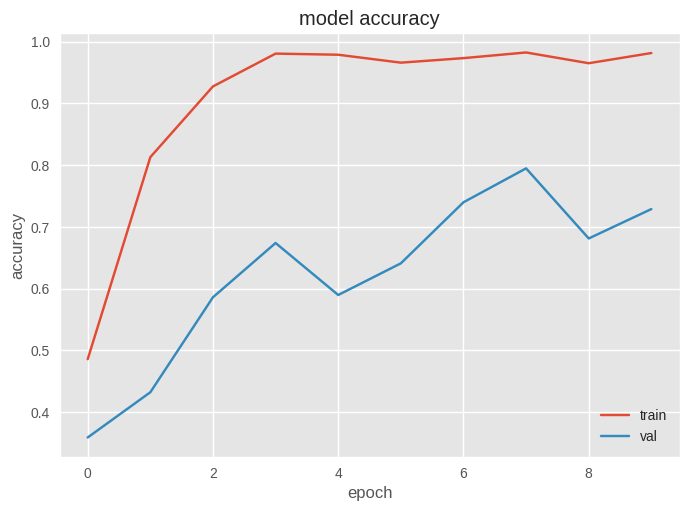

In [26]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['accuracy'],)
plt.plot(teacher_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

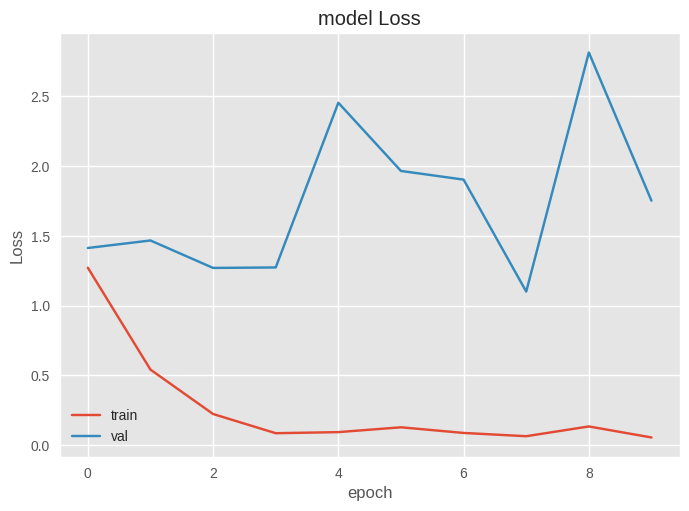

In [27]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['loss'])
plt.plot(teacher_his.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [28]:
Y_val_pred = model.predict(x_val)
print(f'The Teacher model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

9/9 [==============================] - 3s 78ms/step
The Teacher model Accuracy on the Validation Set: 0.7289377289377289


In [29]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 

In [30]:
#Now let's check my predcited values from X_test dataset
# And calculate the y_pred with time
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = model.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

5/5 [==============================] - 1s 226ms/step
My predicted Y_test values are:
 [[1.40139135e-02 7.21210707e-03 9.78774011e-01]
 [2.00214454e-05 4.28913021e-03 9.95690882e-01]
 [1.52704287e-02 1.77518465e-02 9.66977715e-01]
 [2.35387415e-01 7.63213217e-01 1.39931228e-03]
 [9.95950341e-01 3.86056793e-03 1.89136990e-04]
 [3.55689436e-01 1.40858725e-01 5.03451884e-01]
 [5.67586459e-02 4.01059277e-02 9.03135419e-01]
 [1.00000000e+00 8.62220961e-10 0.00000000e+00]
 [6.74900657e-05 9.33246035e-03 9.90599990e-01]
 [6.52970433e-01 3.22714299e-01 2.43152380e-02]
 [9.07552540e-01 7.75013492e-02 1.49460398e-02]
 [2.80398759e-04 1.24563742e-03 9.98473942e-01]
 [5.14373649e-03 6.69779768e-03 9.88158524e-01]
 [9.86780941e-01 6.80651842e-03 6.41250471e-03]
 [6.64733946e-02 4.36531641e-02 8.89873445e-01]
 [2.01738756e-02 1.88513417e-02 9.60974753e-01]
 [1.00938259e-02 1.11564204e-01 8.78342032e-01]
 [2.10821256e-02 9.71971393e-01 6.94648456e-03]
 [9.99991894e-01 8.04883803e-06 1.91593930e-28]
 [

In [31]:
start = timeit.default_timer()
#Your statements here

#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Teacher model with ResNet50 on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My accuracy on Teacher model with ResNet50 on the Test set is: 0.7692307692307693

Time:  0.0029090079999605223 sec


In [32]:
# Classification_report
print(f'Classification Report of Resnet50:\n',classification_report(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

Classification Report of Resnet50:
               precision    recall  f1-score   support

           0       0.49      0.81      0.61        26
           1       0.62      0.89      0.73         9
           2       0.96      0.75      0.84        95

    accuracy                           0.77       130
   macro avg       0.69      0.81      0.73       130
weighted avg       0.84      0.77      0.79       130



**AUC ROC**

Auc Curve on Validation:



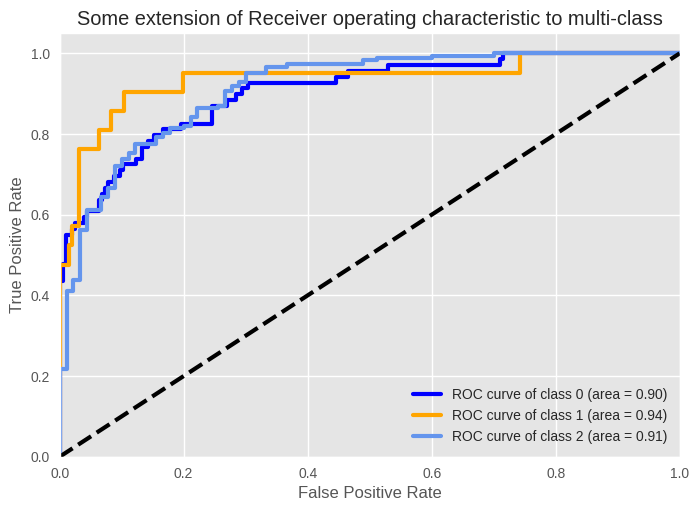

In [33]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Validation:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], Y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), Y_val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Auc Curve on Test set:



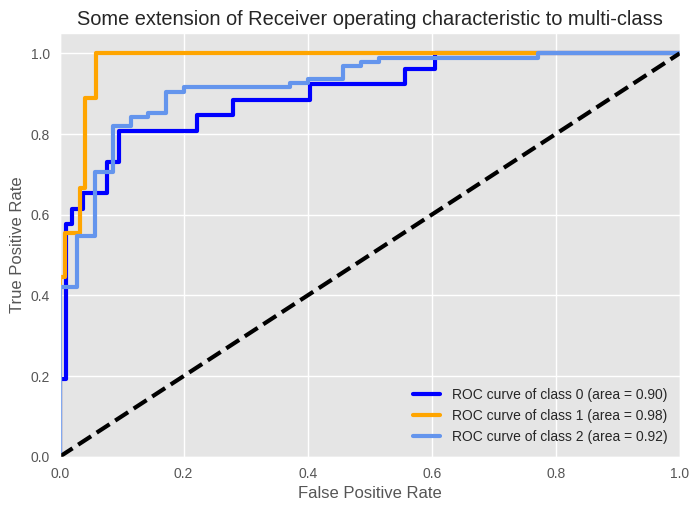

In [34]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Test set:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

**Student Model**

In [ ]:
# Define the student model
# Student model that is stand-alone. We will evaluate its accuracy compared to a teacher trained student model
# Hyperparameters
input_shape = (224, 224, 3) # Input shape of each image
nb_classes = 2

customstudent = Sequential()
customstudent.add(Conv2D(128, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
customstudent.add(MaxPooling2D(pool_size=(2, 2)))
customstudent.add(Conv2D(64, (3, 3), activation='relu'))
customstudent.add(MaxPooling2D(pool_size=(2, 2)))
customstudent.add(Conv2D(32, (3, 3), activation='relu'))
customstudent.add(Dropout(0.25)) # For reguralization

customstudent.add(layers.Flatten())

customstudent.add(layers.Dense(nb_classes))
customstudent.add(layers.Activation('softmax')) # Note that we add a normal softmax layer to begin with


customstudent.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

print(customstudent.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        18464     
_________________________________________________________________
dropout_3 (Dropout)          (None, 52, 52, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)            

In [ ]:
# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets

# Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense_2').output)

In [ ]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

In [ ]:
# Prepare the soft targets and the target data for student to be trained upon
# From our temperature experiment we get temp = 10 is gave is best results
temp = 10
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val)

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 10
test_logits_T = teacher_test_logits / temp

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)

(5596, 2)
(1400, 2)
(5596, 4)
(1400, 4)


In [ ]:
# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
temp = 10
customstudent.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = customstudent.layers[-1].output
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model
customstudent = Model(customstudent.input, output)

customstudent.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_input (InputLayer)       [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 128 3584        conv2d_input[0][0]               
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 111, 111, 128 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 109, 109, 64) 73792       max_pooling2d[0][0]              
____________________________________________________________________________________________

In [ ]:
# Declare knowledge distillation loss function
# This will be a teacher trained student model.
# This uses a knowledge distillation loss function
# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]

    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]

    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)

    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

customstudent.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc]
  )

In [ ]:
# Train the student model
epochs = 20
batch_size = 64
customstudent_student_his = customstudent.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/20
88/88 [==============================] - 16s 184ms/step - loss: 0.0441 - acc: 0.8710 - val_loss: 0.0442 - val_acc: 0.8750
Epoch 2/20
88/88 [==============================] - 16s 184ms/step - loss: 0.0439 - acc: 0.8733 - val_loss: 0.0448 - val_acc: 0.8671
Epoch 3/20
88/88 [==============================] - 16s 185ms/step - loss: 0.0434 - acc: 0.8788 - val_loss: 0.0442 - val_acc: 0.8750
Epoch 4/20
88/88 [==============================] - 16s 185ms/step - loss: 0.0439 - acc: 0.8740 - val_loss: 0.0443 - val_acc: 0.8721
Epoch 5/20
88/88 [==============================] - 16s 185ms/step - loss: 0.0437 - acc: 0.8763 - val_loss: 0.0442 - val_acc: 0.8750
Epoch 6/20
88/88 [==============================] - 16s 186ms/step - loss: 0.0439 - acc: 0.8742 - val_loss: 0.0444 - val_acc: 0.8721
Epoch 7/20
88/88 [==============================] - 16s 186ms/step - loss: 0.0435 - acc: 0.8783 - val_loss: 0.0442 - val_acc: 0.8743
Epoch 8/20
88/88 [==============================] - 16s 186ms/step - 

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.style.use('seaborn')
plt.plot(customstudent_student_his.history['acc'])
plt.plot(customstudent_student_his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(customstudent_student_his.history['loss'])
plt.plot(customstudent_student_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
Y_val_pred_student = customstudent.predict(x_val)
print(f'The CustomStudent model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred_student, axis=1)))

The CustomStudent model Accuracy on the Validation Set: 0.8785714285714286


In [ ]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [ ]:
#Now let's check my predcited values from X_test dataset
import timeit

start = timeit.default_timer()
#Your statements here
y_pred_student = customstudent.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred_student)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My predicted Y_test values are:
 [[0.73105854 0.26894143 0.5249792  0.4750208 ]
 [0.26894143 0.73105854 0.4750208  0.5249792 ]
 [0.73105854 0.26894143 0.5249792  0.4750208 ]
 ...
 [0.73105854 0.2689415  0.5249792  0.47502083]
 [0.31061557 0.68938446 0.4800795  0.5199205 ]
 [0.73105854 0.26894143 0.5249792  0.4750208 ]]

Time:  2.5788797919994977 sec


In [ ]:
start = timeit.default_timer()
#Your statements here

#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Custom Student model on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred_student, axis=1)))

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My accuracy on Custom Student model on the Test set is: 0.9173333333333333

Time:  0.0009702650004328461 sec


In [ ]:
# Classification_report
print(f'Classification Report of Resnet50:\n',classification_report(np.argmax(Y_test, axis=1), np.argmax(y_pred_student, axis=1)))

Classification Report of Resnet50:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1500
           1       0.96      0.87      0.91      1500

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



Auc Curve on Validation:



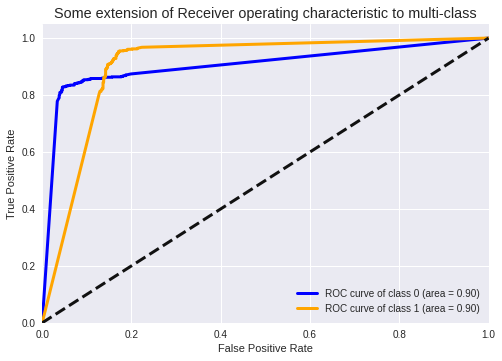

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Validation:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_new[:, i], Y_val_pred_student[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_new.ravel(), Y_val_pred_student.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Auc Curve on Test set:



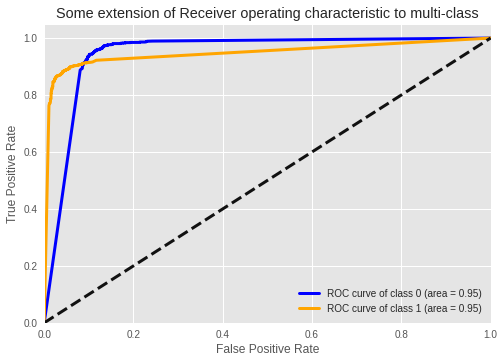

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Test set:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred_student[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred_student.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

-----